In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train Data Loading

In [24]:
train_data = pd.read_excel('../_github/Data/train_data.xlsx')
train_data = train_data.convert_dtypes()
test_data = pd.read_excel('../_github/Data/test_data.xlsx')
test_data = test_data.convert_dtypes()

In [25]:
display(train_data.head())
print(train_data.info())
train_data.shape,test_data.shape

,y,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,duration,campaign,pdays,previous,poutcome
0,yes,66,retired,married,secondary,no,2048,no,no,cellular,27,aug,212,1,-1,0,Not Specified
1,no,49,admin.,single,primary,no,181,yes,no,Not Specified,8,may,161,3,-1,0,Not Specified
2,no,41,blue-collar,divorced,primary,no,-129,yes,no,cellular,18,may,176,1,-1,0,Not Specified
3,no,42,Not Specified,single,Not Specified,no,1316,no,no,Not Specified,5,jun,285,1,-1,0,Not Specified
4,no,45,services,married,secondary,no,1621,no,no,cellular,18,aug,122,8,-1,0,Not Specified


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   y             36168 non-null  string
 1   age           36168 non-null  Int64 
 2   job           36168 non-null  string
 3   marital       36168 non-null  string
 4   education     36168 non-null  string
 5   default       36168 non-null  string
 6   balance       36168 non-null  Int64 
 7   housing       36168 non-null  string
 8   loan          36168 non-null  string
 9   contact       36168 non-null  string
 10  day_of_month  36168 non-null  Int64 
 11  month         36168 non-null  string
 12  duration      36168 non-null  Int64 
 13  campaign      36168 non-null  Int64 
 14  pdays         36168 non-null  Int64 
 15  previous      36168 non-null  Int64 
 16  poutcome      36168 non-null  string
dtypes: Int64(7), string(10)
memory usage: 4.9 MB
None


((36168, 17), (9043, 17))

In [26]:
categorical_cols = train_data.select_dtypes(include = 'string').columns
train_data[categorical_cols] = train_data[categorical_cols].astype('category')
cat_train_data = train_data[categorical_cols].copy()
test_data[categorical_cols] = test_data[categorical_cols].astype('category')
cat_test_data = test_data[categorical_cols].copy()

In [27]:
cat_train_data.head()

,y,job,marital,education,default,housing,loan,contact,month,poutcome
0,yes,retired,married,secondary,no,no,no,cellular,aug,Not Specified
1,no,admin.,single,primary,no,yes,no,Not Specified,may,Not Specified
2,no,blue-collar,divorced,primary,no,yes,no,cellular,may,Not Specified
3,no,Not Specified,single,Not Specified,no,no,no,Not Specified,jun,Not Specified
4,no,services,married,secondary,no,no,no,cellular,aug,Not Specified


# Categorical Modeling

In [28]:
cat_cols = cat_train_data.columns[1:]
target_col = "y"

In [29]:
# Evaluation helper
def print_metrics(y_true, y_pred, y_prob):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")

In [30]:
# One-hot encode categorical features
X_train = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).fit_transform(cat_train_data[cat_cols])
y_train = (cat_train_data['y'] == "yes").astype(int).values

X_test = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).fit_transform(cat_test_data[cat_cols])
y_test = (cat_test_data['y'] == "yes").astype(int).values

In [31]:
# Train logistic regression (with balanced class weights for fairness)
cat_model = LogisticRegression(max_iter=1000, class_weight='balanced')
cat_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = cat_model.predict(X_test)
y_prob = cat_model.predict_proba(X_test)[:, 1]
print_metrics(y_test, y_pred, y_prob)

Confusion Matrix:
 [[6324 1662]
 [ 413  644]]

Classification Report:
               precision    recall  f1-score   support

           0      0.939     0.792     0.859      7986
           1      0.279     0.609     0.383      1057

    accuracy                          0.771      9043
   macro avg      0.609     0.701     0.621      9043
weighted avg      0.862     0.771     0.803      9043

ROC AUC: 0.7625


## Continuous Covariates

In [32]:
numeric_cols = ["age","balance","previous"]
num_train_data = train_data[numeric_cols].copy()
num_test_data = test_data[numeric_cols].copy()
y_pred = cat_model.predict(X_train)
y_prob = cat_model.predict_proba(X_train)[:, 1]
num_train_data['cat_prob'] = y_prob
y_pred = cat_model.predict(X_test)
y_prob = cat_model.predict_proba(X_test)[:, 1]
num_test_data['cat_prob'] = y_prob
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

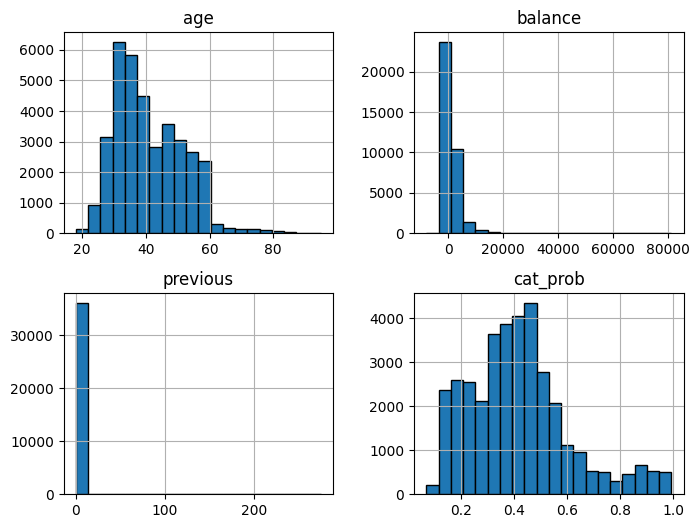

In [33]:
num_train_data.hist(bins = 20,edgecolor ='black',figsize=(8,6))
plt.show()

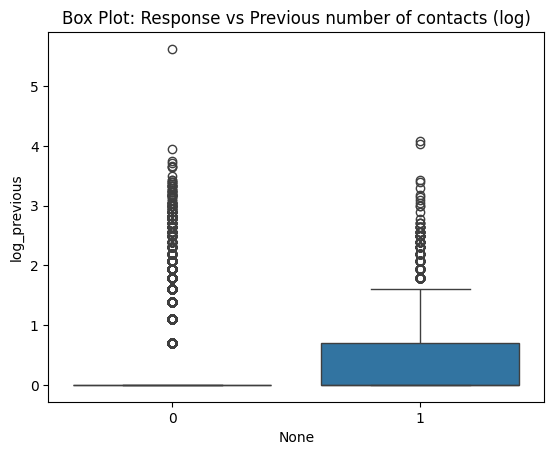

In [34]:
num_train_data['log_previous']=np.log1p(num_train_data['previous'])
num_test_data['log_previous']=np.log1p(num_test_data['previous'])
sns.boxplot(y=num_train_data['log_previous'], x=y_train)
plt.title("Box Plot: Response vs Previous number of contacts (log)")
plt.show()

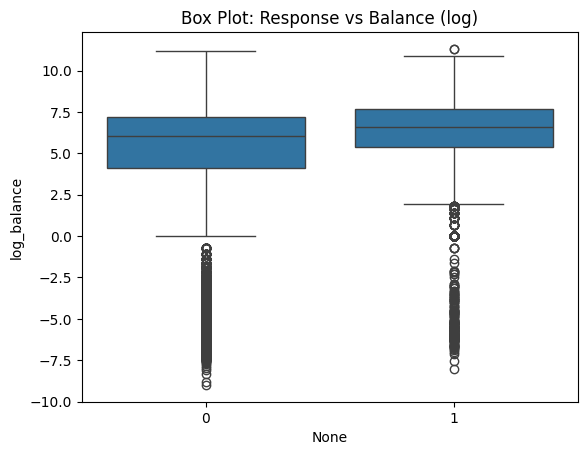

In [35]:
num_train_data["log_balance"] = np.sign(num_train_data["balance"]) * np.log1p(np.abs(num_train_data["balance"]))
num_test_data["log_balance"] = np.sign(num_test_data["balance"]) * np.log1p(np.abs(num_test_data["balance"]))
sns.boxplot(y=num_train_data['log_balance'], x=y_train)
plt.title("Box Plot: Response vs Balance (log)")
plt.show()

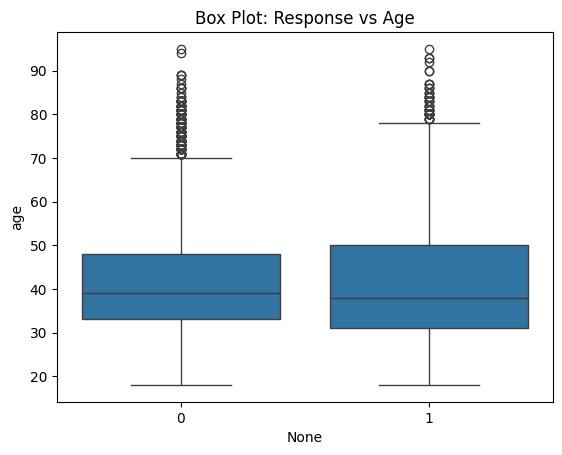

In [36]:
sns.boxplot(y=num_train_data['age'], x=y_train)
plt.title("Box Plot: Response vs Age")
plt.show()

In [37]:
num_train_data.head()

,age,balance,previous,cat_prob,log_previous,log_balance
0,66,2048,0,0.539934,0.0,7.625107
1,49,181,0,0.205093,0.0,5.204007
2,41,-129,0,0.423813,0.0,-4.867534
3,42,1316,0,0.387346,0.0,7.183112
4,45,1621,0,0.396860,0.0,7.391415


In [38]:
y_train.value_counts()

0    31936
1     4232
Name: count, dtype: int64

In [39]:
numvars = ['age','log_balance','log_previous','cat_prob']
num_train_data = num_train_data[numvars].copy()
num_test_data = num_test_data[numvars].copy()

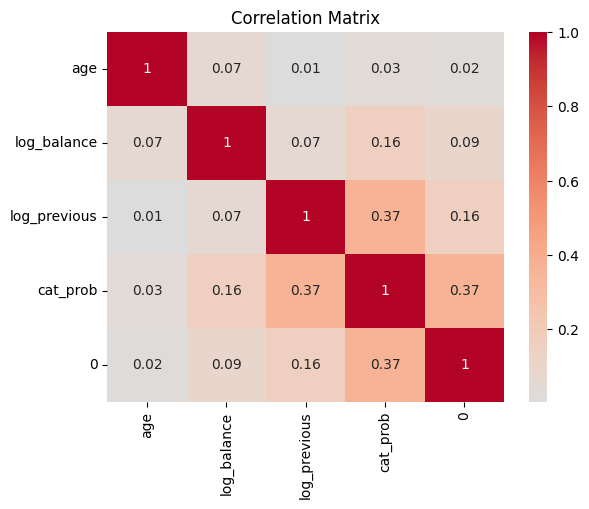

In [40]:
corr = pd.concat([num_train_data,y_train],axis =1).corr()
sns.heatmap(corr,cmap='coolwarm',center = 0,annot=round(corr,ndigits=2))
plt.title("Correlation Matrix")
plt.show()

In [20]:
# # Build a pipeline with scaling + SVM
# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("svm", SVC(kernel="rbf", probability=True))   # kernel='linear' also possible
# ])

# # Fit the SVM model
# svm_clf.fit(num_train_data, y_train)

# # Predictions
# y_pred = svm_clf.predict(num_test_data)
# y_prob = svm_clf.predict_proba(num_test_data)[:, 1]  # probability of class 1

# # Evaluation
# print_metrics(y_test, y_pred, y_prob)

In [21]:
# param_grid = {
#     "svm__C": [0.1, 1, 5, 10],
#     "svm__gamma": ["scale", 0.1, 0.01, 0.001],
#     "svm__kernel": ["rbf"]   # you can test 'linear' also
# }

# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV
# grid = HalvingGridSearchCV(
#     estimator=svm_clf,
#     param_grid=param_grid,
#     scoring="recall",
#     cv=5,
#     factor=2,       # reduction speed — 2 is safe
#     n_jobs=-1,
#     verbose=1
# )

# grid.fit(num_train_data, y_train)

# best_svm = grid.best_estimator_

# print("Best Parameters:", grid.best_params_)
# print("Best CV Score:", grid.best_score_)

# # Predict using best model
# y_pred = best_svm.predict(num_test_data)
# y_prob = best_svm.predict_proba(num_test_data)[:, 1]

# # Evaluate
# print_metrics(y_test, y_pred, y_prob)

In [44]:
# Build pipeline
log_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500))
])

# Fit model
log_clf.fit(num_train_data, y_train)

# Predict
y_pred = log_clf.predict(num_test_data)
y_prob = log_clf.predict_proba(num_test_data)[:, 1]

# Evaluate
print_metrics(y_test, y_pred, y_prob)

Confusion Matrix:
 [[7873  113]
 [ 843  214]]

Classification Report:
               precision    recall  f1-score   support

           0      0.903     0.986     0.943      7986
           1      0.654     0.202     0.309      1057

    accuracy                          0.894      9043
   macro avg      0.779     0.594     0.626      9043
weighted avg      0.874     0.894     0.869      9043

ROC AUC: 0.7676


In [45]:
# Get the fitted logistic regression model inside the pipeline
log_model = log_clf.named_steps["logreg"]

# Coefficients and intercept
coefs = log_model.coef_[0]
intercept = log_model.intercept_[0]

print("Intercept:", intercept)
print("Coefficients:", coefs)
print("Variables:",num_train_data.columns)

Intercept: -2.4084357464696655
Coefficients: [0.01304078 0.14810189 0.02472933 0.97493548]
Variables: Index(['age', 'log_balance', 'log_previous', 'cat_prob'], dtype='object')
